# COX Proportional Hazards Model for GADA-first Outcome

This notebook contains the code for generating supplementary figures 5 and 6.  

For the main analysis, tri-SNP dosage (0, 1 or 2) is fitted along with covariates: sex, having a first degree relative with T1D diagnosis, genetic ancestry, HLA type, country and SNPS previously associated with the outcome.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from lifelines import CoxPHFitter
import pickle
import warnings
warnings.filterwarnings("ignore")
import session_info

session_info.show(html=False)

-----
lifelines           0.26.3
matplotlib          3.9.4
pandas              1.5.3
session_info        1.0.0
-----
IPython             8.18.1
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.5
-----
Python 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) [Clang 11.1.0 ]
macOS-15.6.1-x86_64-i386-64bit
-----
Session information updated at 2025-09-19 10:08


Import metadata

In [2]:
filtered = pd.read_csv("../data/filtered_meta_final.csv")
filtered.head()

,mp257_maskid,family_id,immunochip_id,sex,Cntry,POP,ancestry,POP_reported,t1d,t1d_diag_age_censor,...,rs61751041 (LAMB1),rs6967298 (AUTS2),rs72704176 (ASH1L),rs72717025 (FCGR2A),rs73043122 (RNASET2/MIR3939),rs77532435 (GRB10),rs8013918 (FOS),rs9934817 (RBFOX1),rs389884,rs926552
0,996512,9000247.0,9000247_996512,Male,SWE,EUR,EUR,NaN,1,135.972,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,474979,474979.0,474979_474979,Male,SWE,EUR,EUR,NaN,0,183.443,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,581412,581412.0,581412_581412,Male,SWE,EUR,EUR,NaN,0,186.235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,864158,864158.0,864158_864158,Male,SWE,EUR,EUR,EUR,0,167.017,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,669152,669152.0,669152_669152,Male,SWE,EUR,EUR,NaN,0,174.080,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0


Create ordered hla type list

In [3]:
select_hla = ['DR4/DR8', 'DR3/DR3', 'DR3/DR4',
              'DR4/DR4', "DR1/DR4", "DR4/DR13"]
filtered["hla_type"] = pd.Categorical(filtered["hla_type"], 
               categories=select_hla,
               ordered=True)

Create oredered population list

In [4]:
select_pops = ["EUR", "AMR", "AFR"]
filtered["POP"] = pd.Categorical(
    filtered["POP"],
    categories=select_pops,
    ordered=True)

Create ordered country category

In [5]:
ctry = ["US", "SWE", "FIN", "GER"]
filtered["Country"] = pd.Categorical(
    filtered["Cntry"],
    categories=ctry,
    ordered=True)

Load previous GWAS covariates

In [6]:
snps = pd.read_table("../data/assoc_snps_220824.tsv")
snps.head()

,SNP,Locus,CD_SNP,tTGA_SNP,T1D_SNP,IAA_SNP,SNP_locus
0,rs4851575,"IL18R1, IL18RAP",1,0,0,0,"rs4851575 (IL18R1, IL18RAP)"
1,rs114569351,"PLEK,FBXO48",1,0,0,0,"rs114569351 (PLEK,FBXO48)"
2,rs12493471,"CCR9,LZTFL1,CXCR6",1,0,0,0,"rs12493471 (CCR9,LZTFL1,CXCR6)"
3,rs1054091,"RSPH3,TAGAP",1,0,0,0,"rs1054091 (RSPH3,TAGAP)"
4,rs72704176,ASH1L,1,0,0,0,rs72704176 (ASH1L)


In [7]:
t1d_snps = list(snps.loc[snps["T1D_SNP"] == 1, "SNP_locus"].values)
iaa_snps = list(snps.loc[snps["IAA_SNP"] == 1, "SNP_locus"].values)
tga_snps = list(snps.loc[snps["tTGA_SNP"] == 1, "SNP_locus"].values)
cd_snps = list(snps.loc[snps["CD_SNP"] == 1, "SNP_locus"].values)

## Run coxph model for First Autoantibody GADA

In [8]:
assoc = iaa_snps
event = "Event = First Autoantibody GADA"
common_variables = ['sex', 'FDR-T1D', 'POP', "hla_type", 
                    "Country"] + assoc


common_others = ["Male", 'FDR-T1D']

time, outcome = "GADA_censor", "GADA first"
outcomes = [time, outcome]

### Fit trisnp
This creates supplementary figure 5.

<lifelines.CoxPHFitter: fitted with 7614 total observations, 7232 right-censored observations>
             duration col = 'GADA_censor'
                event col = 'GADA first'
          robust variance = True
      baseline estimation = breslow
   number of observations = 7614
number of events observed = 382
   partial log-likelihood = -3215.65
         time fit was run = 2025-09-19 14:08:22 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
tri-SNP 101            -0.14       0.87       0.15            -0.44             0.15                 0.64                 1.17
FDR-T1D                 0.79       2.20       0.15             0.50             1.07                 1.64                 2.93
rs428595 (PPIL2)        0.62       1.85       0.19             0.25             0.98                 1.29                 2.66
rs1004446 (INS)        -0.08       0.92       0.07            -0.23             0.07                 0.80                 1.07
rs2476601 (PTPN22)      0.31       1.37       0.10             0.12             0.51                 1.12                 1.67
rs2292239 (ERBB3)       0.18       1.20       0.07             0.04             0.33                 1.04                 1.39
rs3184504 (SH2B3)       0.28       1.32       0.07             0.13             0.42                 1.14                 1.53
rs9934817 (RBFOX1)      0.71       2.04       0.21             0.31             1.12                 1.36                 3.05
rs11705721 (PXK/PDHB)   0.12       1.13       0.08            -0.03             0.27                 0.97                 1.31
Male                    0.12       1.13       0.10            -0.08             0.33                 0.92                 1.39
AMR                    -0.03       0.97       0.22            -0.46             0.39                 0.63                 1.48
AFR                     0.43       1.54       0.54            -0.64             1.50                 0.53                 4.46
DR3/DR3                 0.59       1.80       0.32            -0.05             1.22                 0.95                 3.40
DR3/DR4                 0.65       1.92       0.21             0.24             1.07                 1.27                 2.90
DR4/DR4                 0.02       1.02       0.20            -0.37             0.41                 0.69                 1.51
DR1/DR4                -1.34       0.26       0.61            -2.54            -0.14                 0.08                 0.87
DR4/DR13               -0.59       0.55       0.74            -2.04             0.85                 0.13                 2.35
SWE                     0.24       1.27       0.12             0.00             0.48                 1.00                 1.62
FIN                     0.02       1.02       0.15            -0.28             0.31                 0.76                 1.36
GER                    -0.44       0.64       0.27            -0.97             0.08                 0.38                 1.09

                          z      p   -log2(p)
covariate                                    
tri-SNP 101           -0.95   0.34       1.54
FDR-T1D                5.34 <0.005      23.36
rs428595 (PPIL2)       3.33 <0.005      10.16
rs1004446 (INS)       -1.07   0.28       1.82
rs2476601 (PTPN22)     3.13 <0.005       9.18
rs2292239 (ERBB3)      2.47   0.01       6.20
rs3184504 (SH2B3)      3.77 <0.005      12.60
rs9934817 (RBFOX1)     3.47 <0.005      10.92
rs11705721 (PXK/PDHB)  1.58   0.11       3.13
Male                   1.19   0.24       2.09
AMR                   -0.16   0.88       0.19
AFR                    0.79   0.43       1.22
DR3/DR3                1.80   0.07       3.81
DR3/DR4                3.10 <0.005       8.99
DR4/DR4                0.11   0.92       0.13
DR1/DR4          

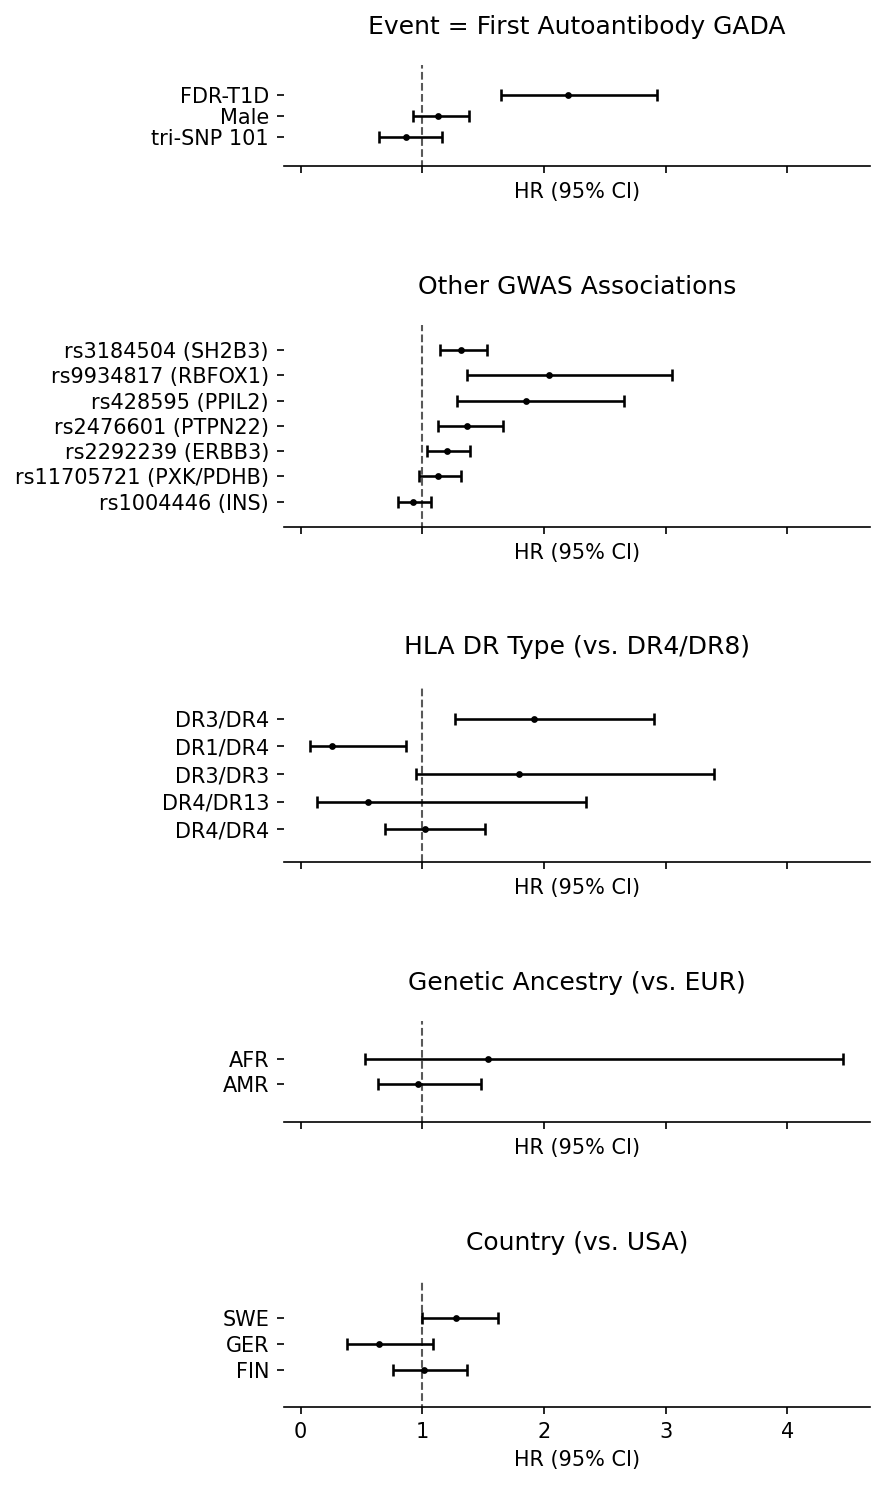

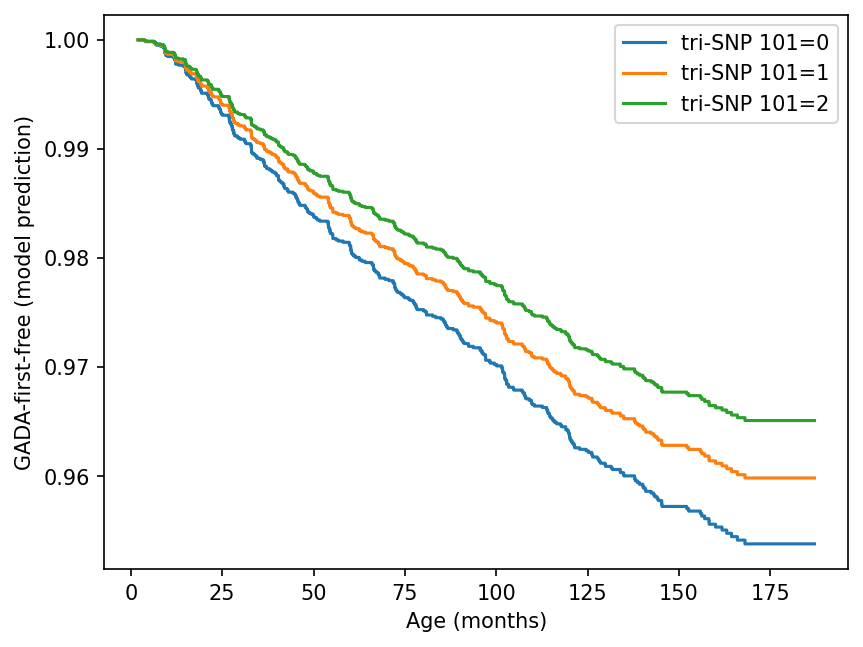

In [9]:
fit_var = "tri-SNP 101"

extension = "cox_gada_all_samples"
ylabel = "GADA-first-free (model prediction)"

variables = [fit_var] + common_variables
data = filtered.loc[:, variables + outcomes].dropna()
dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_hla, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "HLA DR Type (vs. DR4/DR8)", 
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### DR3 homozygotes only
Same analysis as above but limiting to DR3/DR3 homozygote individuals only.

In [10]:
event = "Event = First Autoantibody GADA, DR3 Only"

common_variables = ['sex', 'FDR-T1D', 'POP', 
                    "Country"] + assoc

### Fit trisnp
This will create the supplementary figure 6.

<lifelines.CoxPHFitter: fitted with 1585 total observations, 1500 right-censored observations>
             duration col = 'GADA_censor'
                event col = 'GADA first'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1585
number of events observed = 85
   partial log-likelihood = -580.70
         time fit was run = 2025-09-19 14:08:28 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
tri-SNP 101            -0.34       0.71       0.21            -0.75             0.07                 0.47                 1.07
FDR-T1D                 1.04       2.84       0.28             0.50             1.59                 1.64                 4.89
rs428595 (PPIL2)        0.20       1.23       0.51            -0.80             1.21                 0.45                 3.35
rs1004446 (INS)        -0.14       0.87       0.17            -0.48             0.19                 0.62                 1.21
rs2476601 (PTPN22)      0.41       1.51       0.21             0.00             0.82                 1.00                 2.28
rs2292239 (ERBB3)       0.25       1.28       0.15            -0.05             0.55                 0.95                 1.74
rs3184504 (SH2B3)       0.19       1.21       0.15            -0.10             0.48                 0.91                 1.61
rs9934817 (RBFOX1)     -0.02       0.98       0.59            -1.18             1.14                 0.31                 3.13
rs11705721 (PXK/PDHB)   0.24       1.27       0.16            -0.08             0.56                 0.93                 1.75
Male                    0.19       1.21       0.22            -0.25             0.63                 0.78                 1.88
AMR                    -0.43       0.65       0.62            -1.65             0.79                 0.19                 2.20
AFR                     0.21       1.23       0.81            -1.38             1.79                 0.25                 6.02
SWE                    -0.01       0.99       0.24            -0.49             0.47                 0.61                 1.60
FIN                    -0.80       0.45       0.44            -1.67             0.06                 0.19                 1.07
GER                    -0.18       0.83       0.46            -1.08             0.72                 0.34                 2.05

                          z      p   -log2(p)
covariate                                    
tri-SNP 101           -1.64   0.10       3.31
FDR-T1D                3.75 <0.005      12.47
rs428595 (PPIL2)       0.40   0.69       0.53
rs1004446 (INS)       -0.84   0.40       1.33
rs2476601 (PTPN22)     1.96   0.05       4.34
rs2292239 (ERBB3)      1.62   0.11       3.24
rs3184504 (SH2B3)      1.30   0.19       2.38
rs9934817 (RBFOX1)    -0.03   0.97       0.04
rs11705721 (PXK/PDHB)  1.49   0.14       2.86
Male                   0.86   0.39       1.36
AMR                   -0.69   0.49       1.03
AFR                    0.26   0.80       0.32
SWE                   -0.04   0.97       0.05
FIN                   -1.81   0.07       3.84
GER                   -0.40   0.69       0.54
---
Concordance = 0.68
Partial AIC = 1191.40
log-likelihood ratio test = 35.22 on 15 df
-log2(p) of ll-ratio test = 8.77

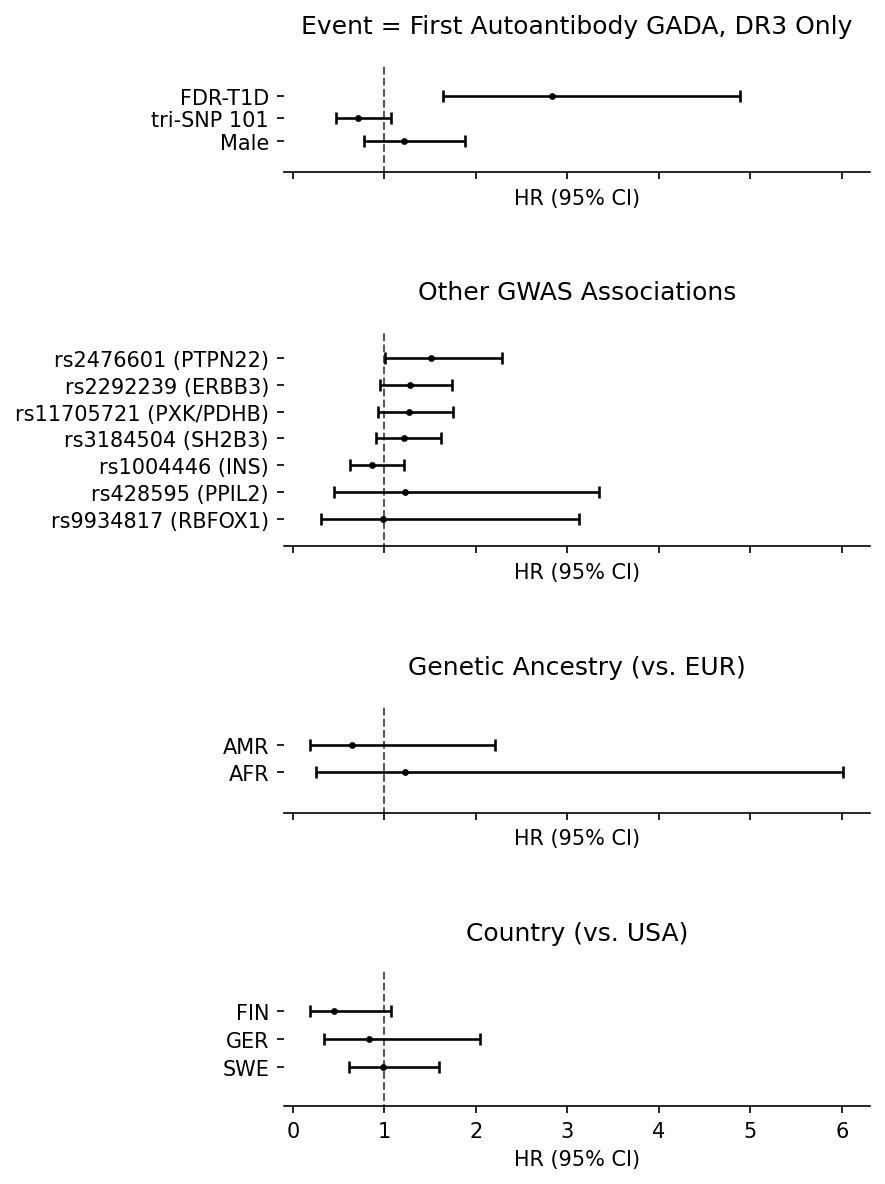

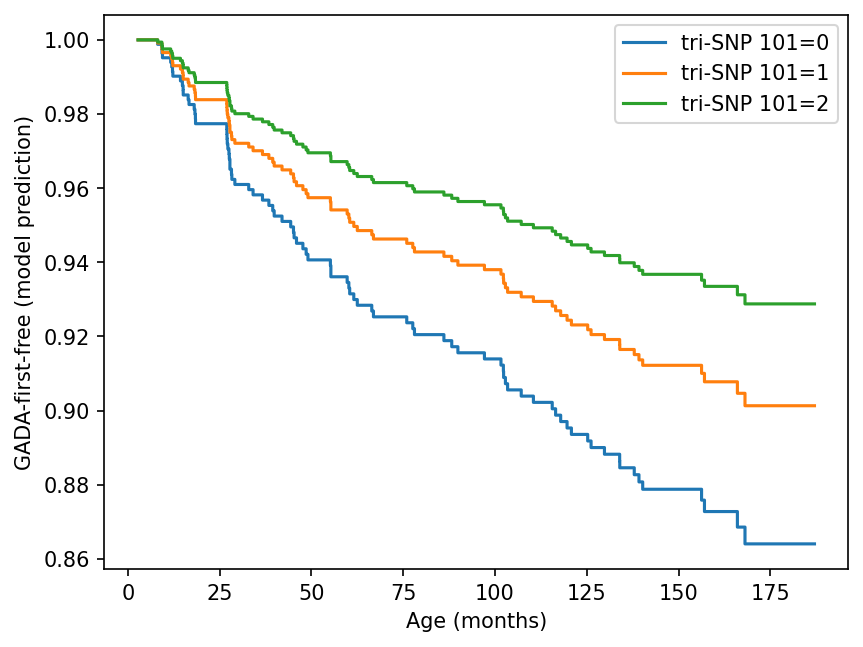

In [11]:
fit_var = "tri-SNP 101"

extension = "cox_gada_dr3_samples"
ylabel = "GADA-first-free (model prediction)"

variables = [fit_var] + common_variables

data = filtered.loc[filtered["hla_type"] == "DR3/DR3",
                    variables + outcomes].dropna()

dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)